In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.decomposition import PCA
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
data = np.load("./datasets/sampled15000_processed_text.npz", allow_pickle=True)
# dataset = pd.DataFrame(data, columns=["GENRE", "DESCRIPTION"])
dataset = pd.DataFrame({key: data[key] for key in  ("GENRE", "DESCRIPTION")})

In [3]:
dataset.isnull().any()

GENRE          False
DESCRIPTION    False
dtype: bool

In [4]:
dataset.GENRE.unique()

array(['documentary', 'crime', 'drama', 'short', 'comedy', 'family',
       'adult', 'music', 'horror', 'reality-tv', 'musical', 'thriller',
       'biography', 'western', 'adventure', 'sport', 'action', 'romance',
       'talk-show', 'animation', 'mystery', 'sci-fi', 'game-show',
       'history', 'fantasy', 'war', 'news'], dtype=object)

In [5]:
dataset.count()

GENRE          84997
DESCRIPTION    84997
dtype: int64

In [6]:
label = LabelEncoder()
Labels = dataset.GENRE.unique() 
dataset["GENRE"] = label.fit_transform(dataset.GENRE)
dataset.head()

,GENRE,DESCRIPTION
0,7,film swedish civil aviation history pioneers e...
1,6,slippery rodney haines runs high class gamblin...
2,8,teen age mother angelo forced give baby adopti...
3,7,jeffrey werbock lighting salesman new jersey f...
4,7,director derek hart takes never shows never se...


In [7]:
tfid = TfidfVectorizer(max_features=6000)
X_input = tfid.fit_transform(dataset.DESCRIPTION)
X_input = pd.DataFrame.sparse.from_spmatrix(X_input)
# X_input = X_input.toarray()
Y_input = dataset.GENRE
X_input.shape

(84997, 6000)

In [8]:
smote = SMOTE()
X_input_smote, Target_smote = smote.fit_resample(X_input, Y_input)

In [9]:
Target_smote.value_counts().to_frame()

,count
GENRE,
7,15000
2,15000
25,15000
10,15000
12,15000
11,15000
20,15000
16,15000
3,15000


In [10]:

pca = PCA(n_components=800)
X_smote_pca = pca.fit_transform(X_input_smote) 


In [11]:
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote_pca, Target_smote, test_size=0.2, random_state=44, shuffle =True
                                                                            ,stratify=Target_smote)
print('X_train shape is ' , X_train_smote.shape)
print('X_test shape is ' , X_test_smote.shape)
print('y_train shape is ' , y_train_smote.shape)
print('y_test shape is ' , y_test_smote.shape)

X_train shape is  (324000, 800)
X_test shape is  (81000, 800)
y_train shape is  (324000,)
y_test shape is  (81000,)


In [12]:
y_train_smote.value_counts().to_frame()
len(y_train_smote.unique())

27

In [13]:
model = Sequential([
    Dense(512, activation='relu', input_dim=800),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.35),
    Dense(128, activation='relu'),
    Dense(len(y_train_smote.unique()), activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',  # For multiclass
              metrics=['accuracy'])

/Users/shyaronrai/Desktop/train data/.conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4)

# Train the model
history = model.fit(
    X_train_smote, y_train_smote,
    validation_split=0.25,
    epochs=50,
    batch_size=128,
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)

Epoch 1/50
1899/1899 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9309 - loss: 0.2037 - val_accuracy: 0.9230 - val_loss: 0.2527 - learning_rate: 5.0000e-05
Epoch 2/50
1899/1899 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9322 - loss: 0.1961 - val_accuracy: 0.9231 - val_loss: 0.2537 - learning_rate: 5.0000e-05
Epoch 3/50
1899/1899 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9327 - loss: 0.1952 - val_accuracy: 0.9231 - val_loss: 0.2516 - learning_rate: 5.0000e-05
Epoch 4/50
1899/1899 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9351 - loss: 0.1888 - val_accuracy: 0.9235 - val_loss: 0.2511 - learning_rate: 5.0000e-05
Epoch 5/50
1899/1899 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9356 - loss: 0.1869 - val_accuracy: 0.9244 - val_loss: 0.2478 - learning_rate: 5.0000e-05
Epoch 6/50
1899/1899 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9364 - loss: 0.1841 - val_accuracy: 0.9249 - val_loss: 0.2497 - learning_rate: 5.0000e-05
Epoch 7/50
1899/1899 ━━━━━━━━━━━━━━━━━━━━ 11s 

In [17]:
results = model.evaluate(X_test_smote, y_test_smote)
print(f"Test Accuracy: {results[1]:.2f}")

2532/2532 ━━━━━━━━━━━━━━━━━━━━ 2s 855us/step - accuracy: 0.9232 - loss: 0.2557
Test Accuracy: 0.92


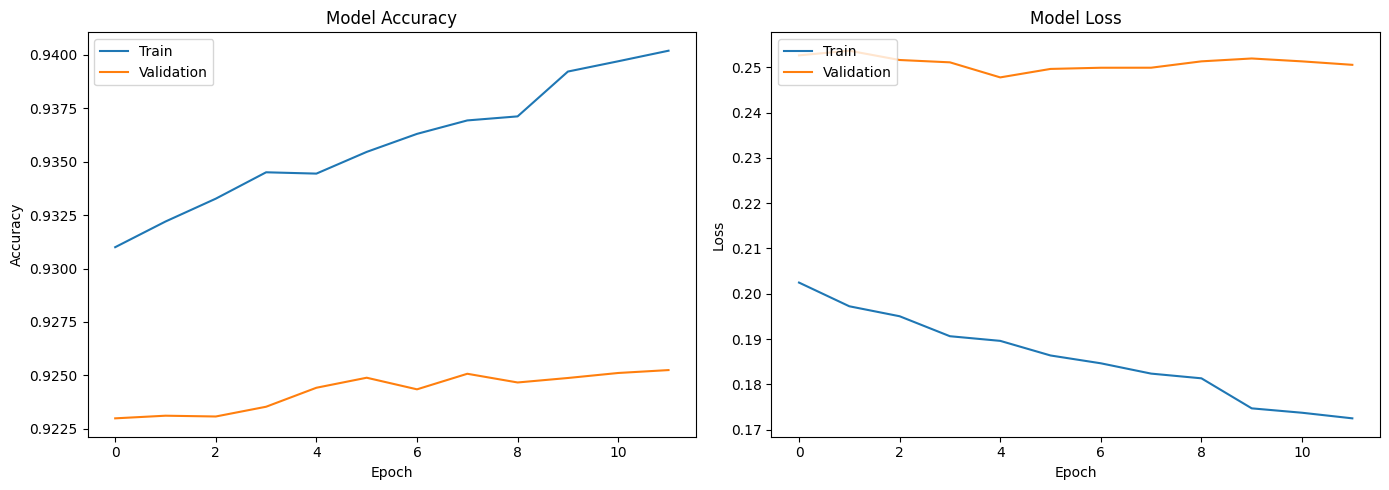

In [18]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


2532/2532 ━━━━━━━━━━━━━━━━━━━━ 2s 722us/step


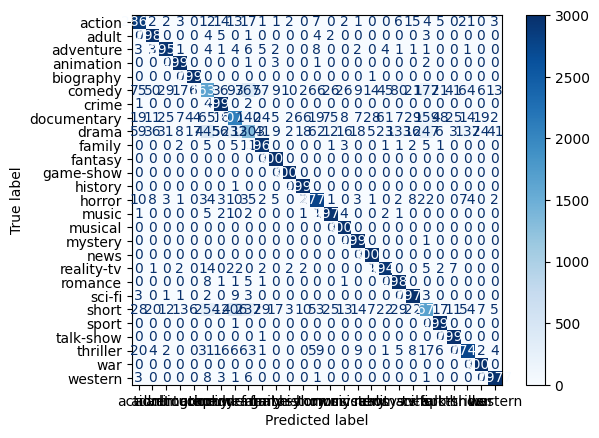

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predicting the labels for the test set
y_pred_smote = np.argmax(model.predict(X_test_smote), axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test_smote, y_pred_smote)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [20]:
# Save the model
model.save('./models/genre_prediction_model.h5')


In [22]:
import pickle
# Save the PCA transformation
with open('./models/pca_transform.pkl', 'wb') as file:
    pickle.dump(pca, file)

# Save the TFIDF vectorizer
with open('./models/tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(tfid, file)

In [23]:
# Print the genre mapping
genre_mapping = dict(zip(label.classes_, label.transform(label.classes_)))
print("Genre Mapping:")
for genre, idx in genre_mapping.items():
    print(f"{idx}: {genre}")

Genre Mapping:
0: action
1: adult
2: adventure
3: animation
4: biography
5: comedy
6: crime
7: documentary
8: drama
9: family
10: fantasy
11: game-show
12: history
13: horror
14: music
15: musical
16: mystery
17: news
18: reality-tv
19: romance
20: sci-fi
21: short
22: sport
23: talk-show
24: thriller
25: war
26: western
